In [1]:
# By chat model we mean LLM model which operates with chats 
import os 
import json
from openai import OpenAI

import threading

from langchain_openai import ChatOpenAI 
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
from typing import Literal , Optional

## check performance in agent workflow 
from typing import TypedDict, Annotated, List, Dict, Optional
from langchain_core.messages import BaseMessage, AnyMessage, ToolMessage,HumanMessage, AIMessage, SystemMessage
from langgraph.graph import add_messages , START, END , StateGraph
from IPython.display import Image, display 
from langgraph.checkpoint.memory import MemorySaver

from googleapiclient.discovery import build
from urllib.parse import urlparse

# prepare model for embeddings  
from langchain_openai import OpenAIEmbeddings 
from langchain_core.tools import tool, StructuredTool


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import numpy.typing as npt

from tavily import TavilyClient 

import subprocess
from IPython.display import Image, display


## OpenAI configuration
api_key_var = os.environ.get("OPENAI_API_KEY")
#print("OpenAI API: " , api_key_var)


# keys for tavily 
tavily_api = os.environ.get("TAVILY_API_KEY")
#print("Tavily API: " , tavily_api)

# api for goole
api_google = os.environ.get('GOOGLE_API_KEY')
#print("Google API: " , api_google)

# define search engine
SEARCH_ENGINE_ID = '26dda816634bd4044'


## word count 
def count_words_whitespace(s: str) -> int:
    return len(s.split())

class WordCounter:
    def __init__(self, word_in: int = 0, word_out: int = 0):
        self.word_input = word_in
        self.word_output = word_out

    def add_word_in(self, text: str) -> None:
        self.word_input += count_words_whitespace(text)

    def add_word_out(self, text: str) -> None:
        self.word_output += count_words_whitespace(text)


counter = WordCounter()



d:\MICB_Projects\8_aml_detective\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


#### Test OpenAI SDK - Azure Foundry

In [2]:
#client = ChatOpenAI(
#    model="gpt-4.1",  # ← Set once here
#    base_url=endpoint, api_key=api_key
#)
  # Model configured once
  # Every call uses the same model
  # Good for consistent chains/agents
  # note # BadRequestError: Error code: 400 - {'error': {'code': 'unknown_model', 'message': 'Unknown model: gpt-3.5-turbo', 'details': 'Unknown model: gpt-3.5-turbo'}}
    # 3.5 is default but it must be created as asset

#client = OpenAI(
#    base_url=endpoint, api_key=api_key )

#response = client.chat.completions.create(
#    model="gpt-4.1",  # ← Must specify each call
#    messages=[...] )

  # One client, many models
  # Flexible per request
  #Good for dynamic model switching

## Commants on endpoins
endpoint = 'https://datam-mhtcc5x5-westeurope.cognitiveservices.azure.com/openai/v1'
# The SDK automatically appends /chat/completions and other paths

# azure https://datam-mhtcc5x5-westeurope.cognitiveservices.azure.com/openai/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview
# This is the direct REST API endpoint, Used for raw HTTP requests (curl, requests library, etc.)

api_key_azure_41 = os.environ.get('OPENAI_API_KEY_AZURE_41')
print(f"API Key loaded: {api_key_azure_41[:3]}..." if api_key_azure_41 else "Not found!")

API Key loaded: B0Z...


In [3]:
# Prepare embedding model
embedding_main = OpenAIEmbeddings(api_key=api_key_var, model="text-embedding-3-small")
embedding_cross_lang = OpenAIEmbeddings(api_key=api_key_var, model="text-embedding-3-large")

# For HyDE comparison we will employ large embedding model for richer semantic representation
# Larger model should be able to capture same concepts in different languages 
# Similar concepts should be positioned closer in the vector space

# Test with similar concepts + unrelated text
test_sentences = [
    "Искусственный интеллект меняет мир",        # AI is changing the world (Russian)
    "Artificial intelligence is changing the world",  # AI is changing the world (English) - fixed typo "word" -> "world"
    "Я люблю есть пиццу по вечерам"              # I love eating pizza in the evenings (unrelated)
]

# Get embeddings
#embeddings = [np.array(embedding_cross_lang.embed_query(x)).reshape(1, -1) for x in test_sentences]

# Calculate similarities
#print("Similarity between Russian and English (should be HIGH):")
#print(f"  {cosine_similarity(embeddings[0], embeddings[1])[0][0]:.4f}")

#print("\nSimilarity between Russian AI and Pizza (should be LOW):")
#print(f"  {cosine_similarity(embeddings[0], embeddings[2])[0][0]:.4f}")

#print("\nSimilarity between English AI and Pizza (should be LOW):")
#print(f"  {cosine_similarity(embeddings[1], embeddings[2])[0][0]:.4f}")

#del embeddings

# large vs small:
# better at capturing same meaning in different languages

In [4]:
!jupyter nbconvert --to python 4_5_2_research_assistant.ipynb

[NbConvertApp] Converting notebook 4_5_2_research_assistant.ipynb to python
[NbConvertApp] Writing 89813 bytes to 4_5_2_research_assistant.py


#### LLM models api definition

In [5]:
# Model to create payload 
llm_payload = ChatOpenAI(
    model="gpt-4.1-mini",  
    temperature=0.2,     
    max_tokens=500,      
    top_p=0.95,          
    timeout=15,         
)


## we also need to generate names variations in different languages
llm_names_variation = ChatOpenAI(
    model="gpt-4.1-mini",   # note the hyphen
    temperature=0.0,        # pure extraction/translation
    timeout=30,
    max_retries=3,
    max_tokens=50          # we only need one short line
)



# Translation and key terms extraction from short input
llm_translation_or_terms = ChatOpenAI(
    model="gpt-4.1-mini",  # BEST: Cheapest model that excels at translation tasks
                          # Translation is pattern-matching, doesn't need reasoning power
                          # GPT-4o-mini handles languages perfectly at 10x lower cost
    
    temperature=0.1,      # BEST: Near-deterministic output for consistent translations
                          # Translation should be consistent, not creative
                          # 0.1 allows tiny variation while preventing hallucinations
    
    max_tokens=500,       # BEST: Perfect for short translations and key terms
                          # Prevents model from over-explaining or adding fluff
                          # Saves money by limiting output length
    
    timeout=5,           # BEST: Translation should be fast, 5s is generous
                          # If it takes longer, something's wrong with the request
                          # Prevents hanging requests from eating budget
    
    max_retries=2         # BEST: Translation usually works first try
                          # 2 retries handles temporary network issues
                          # More retries waste time and money on bad requests
)

# # generate persona
llm_class_generation = ChatOpenAI(
    model="gpt-4.1-mini",     # BETTER: Cheaper, perfectly capable for structured output
    temperature=0.2,         # BEST: Near-deterministic for consistent structure
    max_tokens=1000,         
    timeout=60,             
    max_retries=2           # ADEQUATE: Structured output usually works first try
)
# LengthFinishReasonError: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=200, prompt_tokens=426, total_
# APITimeoutError: Request timed out.
# 4.0 mini replaced with 4.1 as it offers larger context allowing to simulate more experts


llm_hyde_generation = ChatOpenAI(
    model="gpt-4.1-mini",     # OPTIMAL: Cost-effective for creative writing
    temperature=0.5,         # BEST: Creative variation for different journalist styles
    max_tokens=500,          
    timeout=60,            
    max_retries=2          
)


########################################### AZURE
# Error generating reputation summary: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your 
# prompt and retry. To learn more about our content filtering policies please read our documentation:
# https://learn.microsoft.com/en-us/answers/questions/1297066/i-keep-getting-this-error-exception-in-chat-messag

#Error generating reputation summary: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 
#'Your requests to gpt-4.1 for gpt-4.1 in West Europe have exceeded the token rate limit for your current AIServices S0 pricing tier. This request was for ChatCompletions_Create under OpenAI Language Model Instance API. Please retry after 60 seconds. To increase your default rate limit, visit: https://aka.ms/oai/quotaincrease.'}}

# Summary of content extracted from URL with tavily, applieed per each link
llm_url_content_summary = ChatOpenAI(
    base_url = f"{endpoint}" , 
    api_key = api_key_azure_41 , 
    model="gpt-4.1",  # BETTER CHOICE: Your original "gpt-4o" was budget-killer
                          # URL content analysis is mostly extraction/summarization
    
    temperature=0.2,      # BEST: Factual analysis needs consistency, not creativity
    max_tokens=1500,     
    top_p=0.95,         
    timeout=15          
)



# Applied for extract_evidence_claims, consolidates results from Multiple summaries
llm_agg_summaries = ChatOpenAI(
    base_url = f"{endpoint}" , 
    api_key = api_key_azure_41 , 

    model="gpt-4.1",      
                          # Multi-document synthesis requires intelligence
                          # Finding connections across articles needs advanced reasoning
                          # 128K context window handles multiple long articles
                          # This is where you should spend your budget
    
    temperature=0.1,      # BEST: Even complex analysis should be consistent
                          # You want reliable insights, not creative interpretations
    
    max_tokens=3000,     
    top_p=0.95,          # GOOD: Allows sophisticated language while staying accurate
    timeout=60,          
    max_retries=3        
)


# Model uses multiple summaries to make conclusion about possible risk 
llm_evaluation = ChatOpenAI( # compare to 4.o should have better instrusction following
    base_url = f"{endpoint}" , 
    api_key = api_key_azure_41 , 
    model="gpt-4.1", # BadRequestError: Error code: 400 - {'error': {'code': 'unknown_model', 'message': 'Unknown model: gpt-4.o', 'details': 'Unknown model: gpt-4.o'}}      
    temperature=0.2,                   
    max_tokens=3000,     
    #top_p=0.95,         
    timeout=1000,          
    max_retries=3        
)
# BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'top_p' is not supported with this model.", 
# 'type': 'invalid_request_error', 'param': 'top_p', 'code': 'unsupported_parameter'}}

## test gpt 5, takes signifficnt time, requires larger timeout
# result = llm_evaluation.invoke("Generate recommendations on how to prepare banana bread")



#### Variations of company names

In [6]:
## now genetate variation names 
import re
def generate_name_regex(company_name: str, llm) -> tuple[str, list[str], re.Pattern]:
    """
    Returns:
        pipe_line: "Original | Russian"
        parts: [Original, Russian]
        name_re: compiled regex matching either variant (case-insensitive)
    """
    prompt = f"""
    You are an expert at generating a single-line string of company name variants separated by '|'.

    OUTPUT FORMAT (choose exactly one based on spaces in the Original name):
    - If the Original name CONTAINS whitespace:
    <ORIGINAL_NAME>|<RUSSIAN_NAME>|<ORIGINAL_NO_SPACES>|<RUSSIAN_NO_SPACES>
    - If the Original name DOES NOT CONTAIN whitespace:
    <ORIGINAL_NAME>|<RUSSIAN_NAME>

    Rules:
    - ORIGINAL_NAME = the input company name verbatim (do not modify punctuation, casing, or suffixes).
    - RUSSIAN_NAME = a **transliteration/phonetic rewrite** of ORIGINAL_NAME into Cyrillic. **Do NOT translate any words** (brand words, common nouns, legal suffixes, country names, etc.). Only rewrite letters to approximate English pronunciation. If the input is already Cyrillic/Russian, repeat it verbatim. If unsure, copy the original as is.
    - ORIGINAL_NO_SPACES = ORIGINAL_NAME with ALL whitespace removed (preserve punctuation/casing). Include ONLY if the Original name contains whitespace.
    - RUSSIAN_NO_SPACES = RUSSIAN_NAME with ALL whitespace removed (preserve punctuation/casing). Include ONLY if the Original name contains whitespace.
    - Preserve hyphens, punctuation, and casing exactly where they appear in ORIGINAL_NAME.
    - Output MUST be exactly one line, no leading/trailing spaces, no extra spaces around '|', no quotes, no notes, no extra variants, no newlines.

    Original name: {company_name}
    """.strip()


    resp = llm.invoke(prompt)
    pipe_line = (getattr(resp, "content", "") or "").strip()

    # Parse "Original | Russian", fallback to original if needed
    parts = [p.strip() for p in pipe_line.split("|")]

    # Compile strict, case-insensitive pattern
    pattern_str = r"(?:%s)" % "|".join(map(re.escape, parts))
    name_re = re.compile(pattern_str, re.IGNORECASE)

    return parts, name_re


## test 
parts, name_re = generate_name_regex("Danube Logistics", llm_names_variation)
print("Variants:", parts)

tests = [
    "Our vendor is Danube Logistics for Q4.",
    "Our vendor is DANUBE LOGISTICS for Q4.",
    "our vendor is danube logistics for q4.",
    "Payment processed for DanubeLogistics yesterday.",
    "PAYMENT PROCESSED FOR DANUBELOGISTICS YESTERDAY.",
    "payment processed for danubelogistics yesterday.",
    "He said \"Danube Logistics\" will handle shipping.",
    "Contract signed with DanubeLogistics, terms apply.",
    "Partners — Danube Logistics — confirmed attendance.",
    "Client=DanubeLogistics; status=active.",
]

for i, s in enumerate(tests, 1):
    print(f"{i:02d}. {'MATCH' if name_re.search(s) else 'NO MATCH'} — {s}")


Variants: ['Danube Logistics', 'Данюб Лоджистикс', 'DanubeLogistics', 'ДанюбЛоджистикс']
01. MATCH — Our vendor is Danube Logistics for Q4.
02. MATCH — Our vendor is DANUBE LOGISTICS for Q4.
03. MATCH — our vendor is danube logistics for q4.
04. MATCH — Payment processed for DanubeLogistics yesterday.
05. MATCH — PAYMENT PROCESSED FOR DANUBELOGISTICS YESTERDAY.
06. MATCH — payment processed for danubelogistics yesterday.
07. MATCH — He said "Danube Logistics" will handle shipping.
08. MATCH — Contract signed with DanubeLogistics, terms apply.
09. MATCH — Partners — Danube Logistics — confirmed attendance.
10. MATCH — Client=DanubeLogistics; status=active.


#### Main classes for workflow

In [7]:
## Support for journalists and HyDe articles 

class Journalist(BaseModel):
    expertise: str = Field(
        description="Primary area of expertise and writing focus."
    )
    perspective: str = Field(
        description="Writing perspective and approach to the topic."
    )
    style: str = Field(
        description="Writing style, tone, and target audience."
    )

class HydePerspectives(BaseModel):
      journalists: List[ Journalist ] = Field( "Comprehensive list of analysts with their roles and affiliations." )

## test generation of personalitis 
journalist_instructions = """

You are creating exactly {max_journalists} AI journalist personas to analyze 
the SAME financial-crime topic from DIFFERENT, NON-OVERLAPPING angles for banking risk assessment.

Topic under investigation: {crime_topic}
Goal: Create persona of journalist which has solid experience in writing articles which occuses company over involement in  {crime_topic}.

OUTPUT FORMAT (MANDATORY)
- Return ONLY a valid HydePerspectives object with exactly {max_journalists} journalists.
- Each journalist has exactly these fields:
  - expertise (short phrase)
  - perspective (2-3 sentences)
  - style (6-10 adjectives/descriptors, comma-separated)
- No extra commentary, headings, or prose.

For each journalist:
- expertise: Their specific risk assessment specialization
- perspective: From what perspective they asses the impact of crime over diffenret economical or social aspects
- style: Their analytical approach to uncovering risks relevant to banking partnerships

UNIQUENESS REQUIREMENTS (MANDATORY)
- Pairwise distinct expertise (not just synonyms; avoid generic labels like “risk analyst”).
- Pairwise distinct perspectives (each must emphasize different indicators/decision criteria).
- style must contain 3–6 tokens; at least TWO tokens must be unique to that persona (not used by any other persona).
- Before returning, self-check all pairs. If any two personas substantially overlap in expertise keywords OR share >50% of style tokens OR rephrase the same perspective, REVISE and re-check.

COVERAGE & DIVERSITY (GUIDANCE, THEN ENFORCE UNIQUENESS)
- Distribute personas across different risk axes. Draw from (but are not limited to):
  • Regulatory/Enforcement (sanctions, consent orders, investigations)
  • Financial/Forensic flows (counterparties, anomalies, cash-intensity)
  • Operational/Governance/TPRM (controls, third parties, processes)
  • Reputational/Media/Stakeholders (controversy persistence, sentiment)
  • KYC/AML/BO/PEP/Sanctions screening (beneficial ownership transparency)
  • Correspondent banking & cross-border exposure
  • Data privacy/consumer protection
  
- If {max_journalists} ≥ 5, ensure at least one persona implicitly covers each of these example 
  archetypes (use them as inspiration; do NOT output role names, reflect them via fields only):
  1) Regulatory Compliance Analyst — statutory/enforcement exposure
  2) Financial Due Diligence Investigator — flows/counterparties/anomalies
  3) Operational Risk Assessor — governance/controls/third-party risk
  4) Reputational Risk Evaluator — media patterns/controversy persistence
  5) KYC/AML Specialist — KYC gaps/BO transparency/PEP & sanctions
- If {max_journalists} < 5, prioritize coverage in this order: KYC/AML → Regulatory → Financial.

FIELD WRITING RULES
- expertise: one crisp, specific phrase tied to the angle (no generic titles).
- perspective: 1–2 sentences listing the key indicators/thresholds/heuristics used to decide on partnership risk (e.g., “weights unresolved consent orders more than remedial plans”).
- style: 3–6 concise descriptors shaping tone/approach (e.g., “forensic, evidence-driven, regulation-centric, conservative”). Ensure ≥2 tokens unique to this persona.

Return ONLY the HydePerspectives object with exactly {max_journalists} journalists."""


#system_message = journalist_instructions.format( crime_topic = "money laundering" , max_journalists= 1)
#structured_llm = llm_class_generation.with_structured_output( HydePerspectives )

# populate values  
#journalists = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of journalists according to instructions")])

# hasattr(journalists,"journalists")
#journalists.model_dump()


In [8]:
# Evidence Lineage tracking 
AllowedClaimType = Literal["allegation","investigation","charge","conviction","plea","fine","settlement","clearance","sanction_listing","other"]

class EvidenceClaim(BaseModel):
    """Track claims extracted from summaries - focused on consolidation"""
    claim_text: str = Field(description="Specific claim made (e.g., 'FinCEN fined company €50M in 2023')")
    claim_type: AllowedClaimType = Field(description="Each article must fit specific only 1 claim type") # should be generated during classification
    supporting_urls: List[str] = Field(description="ALL URLs that mention this claim")
    date_publish: str = Field(description=" Publication date or event date ")


class ClaimsFromSummaries( BaseModel ): 
    evidence_claims: List[EvidenceClaim] = Field(
    description="All extractable claims from the summaries"
      )

# Accountability: Every claim is traced to specific source
# Credibility: Check if the claim is supported by evidence
# Gap identification: We know what information is missing from the data
# Iteration: Check how many times we researched missing evidences 



In [9]:
# Data and Meta for extracted content, per single link
class LinkCollection(BaseModel):
       displayLink: str = Field(description="The display URL shown in search results (usually domain name)")
       link: str = Field(description="The full URL of the search result")
       raw_content: str = Field(default="", description="Content extracted from URL")
       summary: str = Field(default="", description="Summary of content extracted from URL")
       claim_type: str = Field(default="other", description="Each article must fit specific only 1 claim type")
       date_published: Optional[str] = Field( default=None, description="Publication date extracted from content (format: YYYY-MM-DD, or 'Unknown' if not found)" )
       
       hyde_score: Optional[float] = Field(
        default=None,
        description="Max value of similarity between content of web page and HyDe articles"
    )
       
#ContentSummary (claim_type: AllowedClaimType) 
#    ↓ [extract/convert]
#LinkCollection (claim_type: str)       
       
# during article summarizations we generate both summary and assign specific claim  type    

class ContentSummary(BaseModel):
    claim_type: AllowedClaimType = Field(
        description="Primary financial crime classification from content"
    )

    date_published: Optional[str] = Field( default=None,
    description="Publication date extracted from content (format: YYYY-MM-DD, or 'Unknown' if not found)" )

    summary: str = Field(
        description="Detailed summary of financial crime/compliance information present in the content, or statement that no relevant information exists"
    )
    

## test structured output

url_summary_instructions = '''
You are analyzing RAW CONTENT extracted by Tavily to determine if it contains financial crime/compliance information.
Target entity: "{entity_name}"

TASK 1 - EXTRACT DATE (date_published field):
Find the publication date or event date in the content:
- Look for: publication date, article date, press release date, or event date
- Format as: YYYY-MM-DD (e.g., "2023-05-15")
- If multiple dates exist, prefer the publication date over event dates
- If no clear date is found, use: "Unknown"
- Common date locations: header, byline, footer, or first paragraph

TASK 2 - CLASSIFY (claim_type field):
Determine the PRIMARY claim type from the content:
- allegation: Unproven accusations or allegations of wrongdoing
- investigation: Active investigations, probes, or inquiries  
- charge: Formal criminal or civil charges filed
- conviction: Guilty verdicts, convictions, or findings of liability
- plea: Plea agreements, admissions, or guilty pleas
- fine: Monetary penalties, fines, or financial sanctions imposed
- settlement: Settlements, resolved cases, or negotiated agreements
- clearance: Exonerations, dismissals, or cases dropped/closed without findings
- sanction_listing: Sanctions designations, blacklisting, or regulatory listings
- other: Content has no financial crime information OR doesn't fit categories above

TASK 3 - SUMMARIZE (summary field):
Write a detailed factual summary of financial crime/compliance information found in the content.

SCOPE - Include ONLY if explicitly mentioned:
- AML/KYC/transaction monitoring deficiencies or failures
- Money laundering allegations, investigations, charges, or convictions
- Sanctions violations or sanctions-related issues
- Fraud, corruption, bribery, or embezzlement
- Tax evasion or tax-related crimes
- Securities violations or market manipulation
- Regulatory fines, penalties, or enforcement actions
- Court proceedings, settlements, or legal outcomes
- Compliance program failures or remediation efforts

RULES:
- Use ONLY information explicitly stated in RAW CONTENT - no inference or external knowledge
- Always mention "{entity_name}" in the summary if the entity appears in the content
- Include specific details: amounts, timeframes, jurisdictions, allegations, outcomes, remedial actions
- If content has NO financial crime/compliance information, write: "No financial crime or compliance information is present in the content."
- Summary can be multiple sentences if needed to capture important details
- Do NOT include the publication date in the summary - it goes in the date_published field
- RAW CONTENT may include boilerplate (menus/footers/headers), duplicated blocks, and unrelated 
    text—ignore such noise and extract/classify only substantive financial-crime content.


EXAMPLES:

Example 1 (detailed fine/settlement):
date_published: "2023-05-15"
claim_type: "fine"
summary: "FinCEN fined Danube Logistics €50M for AML violations during 2018-2020 related to inadequate transaction monitoring at Estonian branch operations. The settlement included Danube Logistics admitting to deficiencies in their compliance program. As part of the resolution, Danube Logistics agreed to retain an independent compliance monitor for two years and implement enhanced KYC procedures and high-risk counterparty screening."

Example 2 (investigation cleared):
date_published: "2024-01-10"
claim_type: "clearance"
summary: "DOJ closed an 18-month investigation into Danube Logistics regarding alleged sanctions violations related to transactions with embargoed entities. No charges were filed and Danube Logistics was cleared of all allegations. The investigation examined trade financing activities from 2020-2022."

Example 3 (no date found):
date_published: "Unknown"
claim_type: "investigation"
summary: "Prosecutors are conducting a money-laundering probe into Danube Logistics related to suspicious transactions processed between 2021-2022. The investigation involves alleged failures to file suspicious activity reports and inadequate customer due diligence. No formal charges have been filed yet."

Example 4 (irrelevant content):
date_published: "Unknown"
claim_type: "other"
summary: "No financial crime or compliance information is present in the content."

Remember: Extract ALL three fields. Focus on factual content from the text only.
'''

raw_content_1 = ''' Danube Logistics settles AML case with regulator
Publisher: Financial Times
Byline: FT Staff
Date: 2023-05-15

The National Financial Authority (NFA) announced that Danube Logistics agreed to pay a
€50,000,000 penalty to settle alleged anti-money laundering program deficiencies 
occurring between 2018 and 2020. According to the NFA’s statement, the settlement resolves 
findings related to inadequate transaction monitoring and delayed suspicious activity reporting. 
As part of the settlement, Danube Logistics will retain an independent 
compliance monitor for two years and complete a remedial program by Q4 2024. 
The company stated it has overhauled its KYC procedures since 2022 and enhanced screening of high-risk counterparties. 

No criminal charges were filed, and the NFA described the administrative 
matter as “resolved via settlement.” Danube Logistics did not admit or deny the findings.

'''

raw_content_2 = """Company town hall transcript

Welcome everyone to our Q2 product roadmap review. We’ll focus on UI improvements,
faster onboarding, and expanding to two new markets. The session covers customer
feedback and hiring plans for engineering and support. No mention of investigations,
fines, sanctions, legal cases, or compliance topics."""


system_message = url_summary_instructions.format( entity_name = "Danube Logistics")

structured_llm = llm_url_content_summary.with_structured_output( ContentSummary )

# populate values  
output = structured_llm.invoke([SystemMessage(content=system_message)]+
                               [HumanMessage(content=raw_content_2)])

# hasattr(journalists,"journalists")
print( output.model_dump() )
print(output.claim_type, output.summary , output.date_published)



{'claim_type': 'other', 'date_published': 'Unknown', 'summary': 'No financial crime or compliance information is present in the content.'}
other No financial crime or compliance information is present in the content. Unknown


In [10]:

# Support of google search arguments 
class candidate_names(BaseModel):
       comp_names_variation: List[str] = Field(description="Different possible variations of company name")

class search_terms_extraction(BaseModel):
       or_terms: List[str] = Field(description="List of alternative terms and variations for OR search in the specified language")


In [11]:
# main state
class UnifiedResearchState(TypedDict):
    # From UnifiedResearchState
    messages: Annotated[List[AnyMessage], add_messages]
    search_results: List[LinkCollection]
    search_results_raw: List[LinkCollection]
    filtered_results: List[LinkCollection]
    entity_name: str
    expanded_query:str
    num_reques_per_lang : int
    
    # From GenerateAnalystsState
    max_journalists: int
    journalists: List[Journalist]
    hyde_list: List[str]    

    # from evidence collection 
    evidence_claims: List[EvidenceClaim]


In [12]:
## check implementation with Pydantic 
class UnifiedResearchStatePydantic(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list)
    search_results: List[LinkCollection] = Field(default_factory=list)
    search_results_raw: List[LinkCollection] = Field(default_factory=list)
    filtered_results: List[LinkCollection] = Field(default_factory=list)
    entity_name: str = ""
    expanded_query: str = ""
    
    # With defaults
    num_requests_per_lang: int = 3  
    max_journalists: int = 5        
    journalists: List[Journalist] = Field(default_factory=list)
    hyde_list: List[str] = Field(default_factory=list)
    evidence_claims: List[EvidenceClaim] = Field(default_factory=list)

dummy_state =  UnifiedResearchStatePydantic(
    messages = [HumanMessage(content = "Hello")]
)

def test_state( state:UnifiedResearchStatePydantic ) :
    msg = state.messages
    return {"messages":[HumanMessage(content = "Now i am included")] }

dummy_state = test_state(dummy_state)
print(dummy_state)
# add messages only works inside langgraph compiled graph

{'messages': [HumanMessage(content='Now i am included', additional_kwargs={}, response_metadata={})]}


#### Supportive tools definition 

In [13]:
## Function to generate different names of the company
llm_dummy = ChatOpenAI(
    model="gpt-4o-mini",  
    temperature=0.1,     
    max_tokens=100,       
    timeout=5,           
    max_retries=2   )      

entity_name = "Lukoil"

def extract_name_variations(prompt: str, llm, ln: str = "en") -> str:
    """Generate different variations of how a company name might appear in news articles"""
    
    language_mapping = {
        'en': 'English',
        'ru': 'Russian',
        'fr': 'French', 
        'ro': 'Romanian',
        'de': 'German'
    }
    
    full_language_name = language_mapping.get(ln.lower(), 'English')
    
    template = PromptTemplate(
        input_variables=["prompt", "language"],
        template='''
You are a text analysis expert. Extract the company name from this prompt: "{prompt}"
This name will be used as keywords used for google API, to make it focus only on 
sources which contain company name.

Generate 6-7 possible ways this company name could appear in news articles in {language}.


Consider:
1. Full official name with legal entity type (PJSC, LLC, Inc., etc.)
2. Shortened version without legal entity type
3. Common abbreviations or acronyms
4. Alternative spellings or transliterations
5. How it appears in headlines
6. Brand name vs legal name
7. Regional variations

Return ONLY a JSON array of name variations in {language}.
'''
    )
    
    structured_llm = llm.with_structured_output(candidate_names)
    chain = template | structured_llm
    response = chain.invoke({"prompt": prompt, "language": full_language_name})
    
    variations_list = response.comp_names_variation
    variations_list.append(prompt)
    
    return " ".join(variations_list)

# Usage:
#result = extract_name_variations("Lukoil money laundering accusations", llm_dummy, ln="en")
#print(result)

In [14]:
# define argument for google search 

def extract_orterms_from_query(search_query: str, llm, ln: str) -> str:
    """Extract relevant terms from search query for Google orTerms parameter in the specified language
    
    Args:
        search_query (str): The original search query
        llm: Language model instance
        ln (str): Language code ('en', 'ru', 'fr', 'ro', 'de')
        
    Returns:
        str: Space-separated string of OR terms in the specified language
    """
    
    # Language code to full name mapping
    language_mapping = {
        'en': 'English',
        'ru': 'Russian',
        'fr': 'French', 
        'ro': 'Romanian',
        'de': 'German'
    }
    
    # Get full language name or default to English
    full_language_name = language_mapping.get(ln.lower(), 'English')
    
    prompt = PromptTemplate(
        input_variables=["search_query", "language"],
        template='''
You are a search optimization expert. Analyze this search query and extract alternative terms that should be used in Google's orTerms parameter.

IMPORTANT: Generate ALL terms in {language} language. The response must be entirely in the specified language.

Original Query: "{search_query}"

Extract 6-10 alternative terms covering:
1. Company name variations (abbreviations, alternative spellings, transliterations), both in english and  {language}
2. Topic/subject variations (synonyms, related terms, technical terms)
3. Activity variations (different ways to describe the same concept)

For money laundering searches, consider terms like:
- Financial crimes, compliance violations, sanctions evasion
- AML violations, illicit finance, financial misconduct
- Regulatory violations, corruption, fraud

For company names, consider:
- Official names with/without legal entity types
- Common abbreviations, brand names
- Alternative spellings or transliterations

IMPORTANT: Keep each term SHORT - single words or very short phrases work best for OR logic.
CRITICAL: All terms must be in {language} language.

Example for English:
Query: "Search for news about Apple Inc related to tax evasion"
orTerms: ["Apple", "AAPL", "Apple-Inc", "tax-evasion", "tax-avoidance", "taxation", "fiscal", "treasury", "IRS", "revenue"]

Example for Romanian:
Query: "Căutați știri despre Apple Inc legate de evaziunea fiscală"
orTerms: ["Apple", "AAPL", "Apple-Inc", "evaziune-fiscală", "fraudă-fiscală", "taxare", "fiscal", "trezorerie", "venituri", "impozite"]

Example for Russian:
Query: "Поиск новостей об Apple Inc связанных с уклонением от налогов"
orTerms: ["Apple", "AAPL", "Apple-Inc", "уклонение-налогов", "налоговое-мошенничество", "налогообложение", "фискальный", "казначейство", "доходы", "налоги"]

Example for French:
Query: "Rechercher des nouvelles sur Apple Inc liées à l'évasion fiscale"
orTerms: ["Apple", "AAPL", "Apple-Inc", "évasion-fiscale", "fraude-fiscale", "taxation", "fiscal", "trésorerie", "revenus", "impôts"]

Example for German:
Query: "Suchen Sie nach Nachrichten über Apple Inc bezüglich Steuerhinterziehung"
orTerms: ["Apple", "AAPL", "Apple-Inc", "Steuerhinterziehung", "Steuerumgehung", "Steuervermeidung", "Steuerdelikte", "Steuerrecht", "Finanzbehörden", "Steuerprüfung", "Umsätze", "Gewinne", "Steuern"]

Query: "{search_query}"
Language: {language}

Generate ONLY a list of SHORT alternative terms as a JSON array of strings in {language} language.
        '''
    )
    
    structured_llm = llm.with_structured_output(search_terms_extraction)
    chain = prompt | structured_llm
    
    response = chain.invoke({
        "search_query": search_query, 
        "language": full_language_name
    })
    
    # Join the terms with spaces for orTerms parameter
    orterms_string = " ".join(response.or_terms)
    
    return orterms_string

# Usage examples:
# English
#search_query = "Search for news and information about TESLA Company company related to money laundering."
#orterms_for_search = extract_orterms_from_query(search_query, llm_translation_or_terms, "en")

#print(f"Original query: {search_query}")
#print(f"Generated orTerms: {orterms_for_search}")

# Romanian
#search_query = "Căutați știri și informații despre compania PJSC Lukoil Oil Company legate de spălarea banilor."
#orterms_for_search = extract_orterms_from_query(search_query, llm_translation_or_terms, "ro")

#print(f"Original query: {search_query}")
#print(f"Generated orTerms: {orterms_for_search}")

# Russian
#search_query = "Поиск новостей и информации о компании PJSC Lukoil Oil Company связанных с отмыванием денег."
#orterms_for_search = extract_orterms_from_query(search_query, llm_translation_or_terms, "ru")

#print(f"Original query: {search_query}")
#print(f"Generated orTerms: {orterms_for_search}")

# French
#search_query = "Rechercher des nouvelles et informations sur la société PJSC Lukoil Oil Company liées au blanchiment d'argent."
#orterms_for_search = extract_orterms_from_query(search_query, llm_translation_or_terms, "fr")

#print(f"Original query: {search_query}")
#print(f"Generated orTerms: {orterms_for_search}")

# German
#search_query = "Suchen Sie nach Nachrichten und Informationen über die Gesellschaft PJSC Lukoil Oil Company im Zusammenhang mit Geldwäsche."
#orterms_for_search = extract_orterms_from_query(search_query, llm_translation_or_terms, "fr")

#print(f"Original query: {search_query}")
#print(f"Generated orTerms: {orterms_for_search}")



In [15]:
## Function to translate query 
## payload will be adjusted to the language but we also need to aligh language of request 

def translate_query_for_search(query: str, target_lang: str, llm_instance) -> str:
    """
    Translate search query to target language
    
    Args:
        query: Original search query
        target_lang: Target language code (en, ru, fr, ro, de)
        llm_instance: LLM instance for translation
        
    Returns:
        Translated query string
    """
    language_names = {
        "en": "English","ru": "Russian", "fr": "French","ro": "Romanian","de":"German"
    }

    target_language = language_names[target_lang]

    translation_prompt = f"""Translate this search query to {target_language}. 
                            Keep it concise and search-engine friendly.
                            Keep company names in their original form (do not translate company names)
                            Use semantically correct terms for fraud, corruption, and reputation-related concepts
                            Only return the translated query, nothing else:

    Query: {query}

    Translation:"""
        
    try:
        response = llm_instance.invoke(translation_prompt)
        translated = response.content.strip() if hasattr(response, 'content') else str(response).strip()
        print(f"Translated '{query}' -> '{translated}' ({target_language})")

        return translated
    
    except Exception as e:
        print(f"Translation error: {e}. Using original query.")
        return query
    

result = translate_query_for_search(" Information on Money laundering by Lukoil company " , "de" , llm_translation_or_terms)
result 


Translated ' Information on Money laundering by Lukoil company ' -> 'Informationen zur Geldwäsche durch Lukoil Unternehmen' (German)


'Informationen zur Geldwäsche durch Lukoil Unternehmen'

####  Google tool definition

In [16]:
### test google api to simulate bad request error 
# https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list

api_key = api_google
cse_id = SEARCH_ENGINE_ID

service = build("customsearch", "v1", developerKey=api_key)

result = service.cse().list(
            q="Lukoil Money Laundering",
            cx=cse_id, # search engine name defined in the console 
            dateRestrict='y2',  # Agent customizable
            start=1,
            filter='1', # turn on duplicated filter content 
            hl='en', # Agent customizable - user interface language
            lr='en',  # Agent customizable - language of content             
            num=2, # 10 i smax value
            safe='off',
            orTerms='Lukoil', # if incorrectly specified returned dsearch object may not contain classes
            
            siteSearch='en.wikipedia.org',  # Agent customizable - Wikipedia language version
            siteSearchFilter="e"  # Exclude Wikipedia
        ).execute()

result

{'kind': 'customsearch#search',
 'url': {'type': 'application/json',
  'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'},
 'queries': {'request': [{'title': 'Google Custom Search - Lukoil Money Laundering',
    'totalResults': '16200',
    'searchTerms': 'Lukoil Money Laundering',
    'count': 2,
    'startIndex': 1,
    'language': 'en',
    'inputEncoding': 'utf8',
    'out

In [17]:
# search result is stored in items key
# it does not contain the publication date of the article/news. 
if 'items' in result:
    for elem in result["items"]:
        print(elem.get('displayLink') )

home.treasury.gov
www.tradecomplianceresourcehub.com


In [18]:
# Message for llm to create payload 
system_message_google_search = """
                                             
You are a multi-language search assistant. When asked to search for information, 
call the google_search tool for EACH of these 5 languages:
Make exactly {num_reques_per_lang} tool calls (one per language)

1. **Romanian** (ro):
   - hl="ro" (Romanian interface)
   - lr="lang_ro" (Romanian content)
   - wikipedia_lang="ro" (exclude Romanian Wikipedia)

2. **English** (en):
   - hl="en" (English interface)  
   - lr="lang_en" (English content)
   - wikipedia_lang="en" (exclude English Wikipedia)

3. **Russian** (ru):
   - hl="ru" (Russian interface)
   - lr="lang_ru" (Russian content) 
   - wikipedia_lang="ru" (exclude Russian Wikipedia)

4. **French** (fr):
   - hl="fr" (French interface)
   - lr="lang_fr" (French content)
   - wikipedia_lang="fr" (exclude French Wikipedia)
                            
5. **German** (de):
   - hl="de" (German interface)
   - lr="lang_de" (German content)
   - wikipedia_lang="de" (exclude German Wikipedia)

IMPORTANT: Make exactly {num_reques_per_lang} tool calls (one per language). 
For each call, use num_results = {num_reques_per_lang} to retrieve {num_reques_per_lang} search results per language.
Use dateRestrict="y3" (last year) for recent information.

"""

print( system_message_google_search.format(num_reques_per_lang=10) )



                                             
You are a multi-language search assistant. When asked to search for information, 
call the google_search tool for EACH of these 5 languages:
Make exactly 10 tool calls (one per language)

1. **Romanian** (ro):
   - hl="ro" (Romanian interface)
   - lr="lang_ro" (Romanian content)
   - wikipedia_lang="ro" (exclude Romanian Wikipedia)

2. **English** (en):
   - hl="en" (English interface)  
   - lr="lang_en" (English content)
   - wikipedia_lang="en" (exclude English Wikipedia)

3. **Russian** (ru):
   - hl="ru" (Russian interface)
   - lr="lang_ru" (Russian content) 
   - wikipedia_lang="ru" (exclude Russian Wikipedia)

4. **French** (fr):
   - hl="fr" (French interface)
   - lr="lang_fr" (French content)
   - wikipedia_lang="fr" (exclude French Wikipedia)
                            
5. **German** (de):
   - hl="de" (German interface)
   - lr="lang_de" (German content)
   - wikipedia_lang="de" (exclude German Wikipedia)

IMPORTANT: Make ex

In [19]:
# common error BadRequestError: Max 20 URLs are allowed.
# https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list#try-it 

## define function for tool schema
def google_search(query,  num_results = 5, hl="en", lr="lang_en", dateRestrict="y2", wikipedia_lang="en"):

    """
    Search Google using Custom Search API with configurable parameters.
    
    This function performs Google searches and returns structured results including titles, URLs, and snippets.
    The agent can customize language settings, time restrictions, and Wikipedia language exclusions to optimize search results for specific needs.
    
    Parameters:
    -----------
    query : str
        The search query string to execute
    api_key : str  
        Google Custom Search API key
    cse_id : str
        Google Custom Search Engine ID
        
    Agent Customizable Parameters:
    -----------------------------

    num_results : int, always included and defined by user
    Number of results to return (default: 5, max: 10 per API call), Value must not exceed 10, NOT customisable

    hl : str, always included (default: "en")
        Interface language - controls UI language and affects search quality
        Examples: "en", "ru", "de", "fr","ro"
        
    lr : str, always included (default: "lang_en") 
        Content language restriction - filters results by document language
        Examples: "lang_en", "lang_ru", "lang_de", "lang_fr","lang_ro"
        
    dateRestrict : str, always included (default: "d365")
        Time-based filtering for results freshness
        Examples: "d1" (past day), "w1" (past week), "m1" (past month), 
                 "m3" (past 3 months), "m6" (past 6 months), "y1" (past year)
    
    wikipedia_lang : str, always included (default: "en")
        Wikipedia language version to exclude from results
        Possible values: "en" (English), "ru" (Russian), "fr" (French), "ro" (Romanian), "de" (German)
        Maps to domains: en.wikipedia.org, ru.wikipedia.org, fr.wikipedia.org, ro.wikipedia.org, de.wikipedia.org
    
    Returns:
    --------
    list
        List of dictionaries containing search results with keys:
        - 'title': Result title
        - 'link': Result URL  
        - 'snippet': Result description/excerpt
        - Additional metadata from Google API
        
    Example Agent Usage:
    -------------------
    # For Russian content excluding Russian Wikipedia
    results = google_search(query, api_key, cse_id, hl="ru", lr="lang_ru", dateRestrict="y3", wikipedia_lang="ru")
    
    # For French content excluding French Wikipedia
    results = google_search(query, api_key, cse_id, hl="fr", lr="lang_fr", dateRestrict="y3", wikipedia_lang="fr")
    
    # For Romanian content excluding Romanian Wikipedia
    results = google_search(query, api_key, cse_id, hl="ro", lr="lang_ro", dateRestrict="y3", wikipedia_lang="ro")

    # For German content excluding German Wikipedia
    results = google_search(query, api_key, cse_id, hl="de", lr="lang_de", dateRestrict="y3", wikipedia_lang="de")

     # For English content excluding English Wikipedia
    results = google_search(query, api_key, cse_id, hl="en", lr="lang_en", dateRestrict="y3", wikipedia_lang="en")

    """

    print("Executing google_search_payload ...")

    api_key = api_google
    cse_id = SEARCH_ENGINE_ID

    service = build("customsearch", "v1", developerKey=api_key)
    
    # Map language codes to Wikipedia domains
    wikipedia_domains = {
        "en": "en.wikipedia.org",
        "ru": "ru.wikipedia.org", 
        "fr": "fr.wikipedia.org",
        "ro": "ro.wikipedia.org",
        "de": "de.wikipedia.org"
    }
    
    wikipedia_site = wikipedia_domains.get(wikipedia_lang, "en.wikipedia.org")
    
    ## store search results 
    all_results = []
   
    ## query language must be aligned with search parameters
    translated_query = translate_query_for_search(query , hl , llm_translation_or_terms)

    ## orterms
    orterms_for_search = extract_orterms_from_query(translated_query, llm_translation_or_terms, hl )
    #orterms_for_search = extract_name_variations(translated_query, llm_translation_or_terms, hl)
    print("Additional search terms: " , orterms_for_search)
    

    try:
        result1 = service.cse().list(
            q=translated_query,
            cx=cse_id, # search engine name defined in the console 
            dateRestrict=dateRestrict,  # Agent customizable
            start=1,
            filter='1', # turn on duplicated filter content 
            hl=hl, # Agent customizable - user interface language
            lr=lr,  # Agent customizable - language of content             
            num=num_results, 
            orTerms=orterms_for_search, # each document must contain at least one of the additional terms 
            safe='off',
            siteSearch=wikipedia_site,  # Agent customizable - Wikipedia language version
            siteSearchFilter="e"  # Exclude Wikipedia
        ).execute()
        
        if 'items' in result1:
                # Extract only relevant information from each result
                filtered_items = []
                for item in result1['items']:
                    essential_data = {
                        'query':translated_query,
                        'title': item.get('title', ''),
                        'link': item.get('link', ''),
                        'snippet': item.get('snippet', ''),
                        'displayLink': item.get('displayLink', '')
                    }
                    filtered_items.append(essential_data)

                all_results.extend(filtered_items)
    
    except Exception as e:
        print(f"Error getting results: {e}")

    print("Executing google_search_payload DONE ")    

    return all_results



In [20]:
## Test function 
tool_google_search = StructuredTool.from_function( google_search, name = "google_search" )

entity_name = "Lukoil"
query = f"{entity_name} money laundering compliance violations investigations"

# join instructions and entity name
num_reques_per_lang = 10
messages = [ SystemMessage(content = system_message_google_search.format(num_reques_per_lang=10) ) ,  HumanMessage(content=query) ]

## create list of tools, which be called externally with  tool_call['args']
tools = [ tool_google_search  ]
tools_by_name = {tool.name:tool for tool in tools}

# bind first tool to 4o mnodel
llm_with_tools = llm_payload.bind_tools(tools)

# test tool call without payload 
payload = llm_with_tools.invoke( messages )


In [21]:
## check payload values
for tool_call in payload.tool_calls:
    print(f"Tool: {tool_call['name']}")
    print(f"ID: {tool_call['id']}")
    print(f"Args: {tool_call['args']}")
    print("---")
 

Tool: google_search
ID: call_UeMcW2g2I9io3eoL80DrFpoz
Args: {'query': 'Lukoil money laundering compliance violations investigations', 'num_results': 10, 'hl': 'ro', 'lr': 'lang_ro', 'dateRestrict': 'y3', 'wikipedia_lang': 'ro'}
---
Tool: google_search
ID: call_gvbK8EI2GsKEsMI9D9EKouOH
Args: {'query': 'Lukoil money laundering compliance violations investigations', 'num_results': 10, 'hl': 'en', 'lr': 'lang_en', 'dateRestrict': 'y3', 'wikipedia_lang': 'en'}
---
Tool: google_search
ID: call_gv54g7LailXOeL3yVvq5rYua
Args: {'query': 'Lukoil money laundering compliance violations investigations', 'num_results': 10, 'hl': 'ru', 'lr': 'lang_ru', 'dateRestrict': 'y3', 'wikipedia_lang': 'ru'}
---
Tool: google_search
ID: call_LphbWroLLtqiPFMF0BPT1tCd
Args: {'query': 'Lukoil money laundering compliance violations investigations', 'num_results': 10, 'hl': 'fr', 'lr': 'lang_fr', 'dateRestrict': 'y3', 'wikipedia_lang': 'fr'}
---
Tool: google_search
ID: call_r1BWRbMaYDfa4RpzWLoLIiuj
Args: {'query': 'L

In [22]:
# run the function  using single payload
#tool_call = payload.tool_calls[0]
#tool_google_search.invoke( tool_call['args'] )
#print("##-----------------##")

## Now run through app payloads  
#for tool_call in payload.tool_calls: # AI message with payload , last ai message with too l calls
#        tool = tools_by_name[tool_call["name"]]
#        observations = tool.invoke(tool_call["args"])
#        print(observations)

In [23]:
## Dummy unified state

dummy_state = UnifiedResearchState(
    {
        "messages": [HumanMessage(content = "Lukoil" ) ]   
    }   
)

In [24]:
## Node to create payload for the tool
def llm_node(state: UnifiedResearchState):
    """LLM node that generates tool calls"""
    print("Executing llm_node...")
    
    # Get the last message from state
    entity_name  = state["messages"][-1] # human message
    query = f"{entity_name.content} money laundering criminal activity"
    
    ## modified content 
    human_message_updated = HumanMessage(content=query, id=entity_name.id)
    print("Updated human message: " , human_message_updated.content)

    ## Replace content of the original human imput 
    system_message = SystemMessage(content = system_message_google_search.format(num_reques_per_lang = state["num_reques_per_lang"]) )

    messages = [ system_message ,  human_message_updated ]
    
    # Call LLM with tools to generate ai message
    response = llm_with_tools.invoke( messages )
    #print(f"LLM response: {response}")
    #print("State fields " , state)
    
    # return all up to last message, replace last human input , company name(for prompts), expanded query for debugging in English
    return {"messages": state["messages"][:-1] + [human_message_updated, response], "entity_name": entity_name.content , "expanded_query":query }

#print("Test Results: ")
#dummy_state = llm_node(dummy_state) 
#print( dummy_state )

#for msg in dummy_state.get('messages'):
#    if isinstance(msg, AIMessage):
#        for msg_tool  in msg.tool_calls:
#            print(msg_tool.get("args"))

# after payload is populated to AI messages we need to pass args to funcntion
# below implemented sequentially 

In [25]:
## google search tool execution and allocation of seatch results
def tool_node_chunk_selection_exec(state: UnifiedResearchState):
    """Performs the tool call"""
    print("Executing tool_node_chunk_selection_exec...")
    
    result = []
    link_collections = []

    for tool_call in state["messages"][-1].tool_calls: # AI message with payload , last ai message with too l calls
        tool = tools_by_name[tool_call["name"]] # select tool
        observation = tool.invoke(tool_call["args"]) # paste arguments to the tool 
           
        result.append(ToolMessage( # messages are returned by google api not all generated
                       content = observation, 
                       tool_call_id=tool_call["id"] , 
                       name = tool_call['name']))    
        
        # Extract LinkCollection data from observation
        for item in observation:
            if isinstance(item, dict):
                # Check if required keys exist
                if 'displayLink' in item and 'link' in item:
                    link_collection = LinkCollection(
                        displayLink=item['displayLink'],
                        link=item['link']
                    )
                    link_collections.append(link_collection)
                else:
                    # This will only print for items that are missing keys
                    available_keys = list(item.keys())
                    print(f"Item missing required keys. Available keys: {available_keys}")
                    print(f"Item content: {item}")
            else:
                print(f"Item is not a dict, it's: {type(item)}")
        
    # we need to populate LinkCollection class and store in  search_results 

    print("Executing tool_node_chunk_selection_exec END")
    return {"messages": result , "search_results":link_collections }   

print("Test case: ")
#tool_node_chunk_selection_exec(dummy_state)
#output = tool_node_chunk_selection_exec(dummy_state)


Test case: 


In [26]:
## check classes to store initial link data 
#for attr in output.get("search_results")[0]:
#    print(attr)

In [27]:
## function to display flow using cli

def render_mermaid_graph(mermaid_code, output_filename='graph.png', width=700, height=700, cleanup=True):
    """
    Render Mermaid diagram using CLI and display in Jupyter
    """
    # Create temporary mermaid file
    temp_mmd = output_filename.replace('.png', '.mmd').replace('.svg', '.mmd').replace('.pdf', '.mmd')
    
    try:
        # Write mermaid code to file
        with open(temp_mmd, 'w', encoding='utf-8') as f:
            f.write(mermaid_code)
        
        # Build command based on output format
        # Use the Windows .cmd version
        cmd = [
            'C:\\Users\\Admin\\AppData\\Roaming\\npm\\mmdc.cmd',  # Full path to Windows version
            '-i', temp_mmd,
            '-o', output_filename,
            '-w', str(width),
            '-H', str(height)
        ]
        
        # Add size parameters only for PNG/PDF
        if output_filename.endswith(('.png', '.pdf')):
            cmd.extend(['-w', str(width), '-H', str(height), '--scale', '2'])
        
        result = subprocess.run(cmd, capture_output=True, text=True) # we simulate running command like
        
        if result.returncode == 0:
            print(f"Graph rendered successfully: {output_filename}")
            try:
                display(Image(output_filename))
            except:
                print(f"Image saved to {output_filename} but could not display inline")
            return True
        else:
            print(f"Mermaid CLI error: {result.stderr}")
            return False
            
    except FileNotFoundError:
        print("Mermaid CLI not found. Install with: npm install -g @mermaid-js/mermaid-cli")
        return False
    except Exception as e:
        print(f"Error rendering graph: {e}")
        return False
    finally:
        if cleanup and os.path.exists(temp_mmd):
            os.remove(temp_mmd)


#### Prepare Tavily for content extraction

In [28]:
## Generate summary of extracted content

#current approach uses multiple parallel function calls
# function process 1 link 
def generate_url_summary(raw_content: str, llm, entity_name: str, thread_outcomes: dict, url: str):
    
    """
    Generate a focused summary of raw content with emphasis on company reputation 
    and criminal activity using dedicated LLM.
    
    Args:
        raw_content: Text content to analyze
        llm: Language model instance for processing
        entity_name: Company name for context
        thread_outcomes: used to aggregate outputs of paralles processes
        url: used as a key 
        
    Returns:
        threadding is applied , no result returned
        
    """
    
    print(f"Thread for {url} starting...")

    
     # Input validation
    if not raw_content or not raw_content.strip():
        thread_outcomes[url] = "Error: No content provided for analysis"
        print(f"No content found for {url} ")
        return
    
    # Truncate content if too long (prevent token limit issues)
       # skipped, tavily uses  def first_n_words(text: str, n: int) -> str:
    # url_summary_instructions is defined in Main Classes section 
    # now we need  to populate class with date, summary and intent classification  
    #  
    try:
        system_message = url_summary_instructions.format( entity_name = entity_name )
        structured_llm = llm.with_structured_output( ContentSummary )

        # populate values  
        response = structured_llm.invoke([SystemMessage(content=system_message)]+
                                         [HumanMessage(content=raw_content)])
        # contains 3 attributes claim_type, summary , date_published
        # ex. ContentSummary(claim_type='other', date_published='Unknown', summary='No financial crime or compliance information is present in the content.')
        print(response)

         # Validate response
        if not response or not hasattr(response, 'summary'):
            thread_outcomes[url] = "Error: Invalid response from language model"
            return
        
        thread_outcomes[url] = response
        
    except Exception as e:
        # More specific error handling
        error_msg = f"Error generating reputation summary: {str(e)}"
        print(error_msg)  # For debugging
        thread_outcomes[url] = "Error: Could not generate reputation summary due to processing issues"
        return 


# Fixed test call
url_to_raw_content = {
    # allegation
    "https://news.example.com/article/allegation": """Publisher: Market Watch Europe
Date: 2025-01-12
Reporters alleged that Danube Logistics facilitated questionable cash-intensive shipments through third-party brokers in 2023. The article cites unnamed sources and notes no official filings or agency statements. Legal status not confirmed; allegations only.""",

    # investigation
    "https://regulator.example.gov/notices/inquiry-2025-02": """Publisher: National Financial Authority
Date: 2025-02-05
The NFA announced it has opened an investigation into Danube Logistics regarding potential AML/KYC monitoring deficiencies in 2022–2024 cross-border transfers. No fines or charges are imposed at this stage; the probe is ongoing.""",

    # charge
    "https://court.example.org/dockets/indictment-24-771": """Publisher: District Court Bulletin
Date: 2024-11-18
Prosecutors filed criminal charges against a Danube Logistics regional manager for alleged structuring and false statements. The indictment specifies three counts; the company itself is not charged. Arraignment is scheduled next month.""",

    # conviction
    "https://court.example.org/verdicts/2025-03-14": """Publisher: District Court Bulletin
Date: 2025-03-14
A jury convicted a former Danube Logistics contractor on two counts of money laundering tied to 2021 transactions. The order notes no finding against Danube Logistics as a corporate entity. Sentencing set for May.""",

    # plea
    "https://justice.example.gov/releases/plea-agreement-2024-10-02": """Publisher: Ministry of Justice
Date: 2024-10-02
A former operations lead at Danube Logistics entered a guilty plea to one count of failing to file required reports. The plea agreement includes cooperation and a recommended fine; the filing does not charge the company.""",

    # fine
    "https://nfa.example.gov/enforcement/actions/2025-04-20": """Publisher: National Financial Authority
Date: 2025-04-20
The NFA fined Danube Logistics €12,500,000 for AML program deficiencies related to delayed suspicious activity reporting in 2022. The civil penalty order cites inadequate alert tuning and training gaps.""",

    # settlement
    "https://newswire.example.com/releases/settlement-announce": """Publisher: Financial Times
Date: 2023-05-15
Danube Logistics reached a settlement resolving an administrative AML matter with the NFA, agreeing to pay €50,000,000 and retain an independent monitor for two years. The company did not admit or deny the findings; no criminal charges were filed.""",

    # clearance
    "https://regulator.example.gov/notices/closure-2025-06": """Publisher: National Financial Authority
Date: 2025-06-09
Following review, the NFA closed its investigation into Danube Logistics with no enforcement action. The notice states that evidence was insufficient to support alleged violations and the matter is dismissed.""",

    # sanction_listing
    "https://sanctions.example.gov/updates/listing-2024-09-28": """Publisher: Ministry of Finance — Sanctions Directorate
Date: 2024-09-28
The Sanctions Directorate listed Danube Logistics Trading FZE on the national sanctions list for involvement in evasion schemes. The designation imposes asset freezes and prohibits transactions with listed parties.""",

    # other (irrelevant/neutral ops update)
    "https://blog.example.org/posts/ops-expansion": """Publisher: Logistics Today
Date: 2025-03-02
Danube Logistics announced a 40,000 m² distribution center with automated sortation and cold-chain capacity, plus 120 new jobs. The post discusses sustainability features and scheduling software. No legal or compliance topics are mentioned.""",

    "https://blog.example.org/DUMMY" : 'weather in scotland'
}


thread_outcomes = {}

# now trreading
threads = []
entity_name = "Danube Logistics" 

for url, raw_content in url_to_raw_content.items():
    t = threading.Thread( 
        target = generate_url_summary ,
        args = ( raw_content, llm_url_content_summary, entity_name, thread_outcomes, url )
     )
    threads.append(t)

for thread in threads:
    thread.start() 

for thread in threads:
    t.join()


Thread for https://news.example.com/article/allegation starting...
Thread for https://regulator.example.gov/notices/inquiry-2025-02 starting...
Thread for https://court.example.org/dockets/indictment-24-771 starting...
Thread for https://court.example.org/verdicts/2025-03-14 starting...
Thread for https://justice.example.gov/releases/plea-agreement-2024-10-02 starting...
Thread for https://nfa.example.gov/enforcement/actions/2025-04-20 starting...
Thread for https://newswire.example.com/releases/settlement-announce starting...
Thread for https://regulator.example.gov/notices/closure-2025-06 starting...
Thread for https://sanctions.example.gov/updates/listing-2024-09-28 starting...
Thread for https://blog.example.org/posts/ops-expansion starting...
Thread for https://blog.example.org/DUMMY starting...
claim_type='sanction_listing' date_published='2024-09-28' summary='The Sanctions Directorate of the Ministry of Finance listed Danube Logistics Trading FZE on the national sanctions list f

In [29]:
#thread_outcomes
#thread_outcomes['https://regulator.example.gov/notices/closure-2025-06'].claim_type

In [30]:
# test extraction 
tavily_client = TavilyClient(api_key=tavily_api)
url = 'https://www.ebrd.com/home/news-and-events/news/2023/ebrd-will-appeal-imposed-external-administration-of-assets-of-moldovas-danube-logistics-srl.html'
output = tavily_client.extract(urls=url, extract_depth='basic', format = 'markdown') 


claim_type='other' date_published='2025-03-02' summary='No financial crime or compliance information is present in the content.'
claim_type='clearance' date_published='2025-06-09' summary='The National Financial Authority closed its investigation into Danube Logistics with no enforcement action taken. The notice states that evidence was insufficient to support alleged violations and the matter is dismissed.'


In [31]:
output
# single large string which includes the whole page, footers, cookies, article body, header, navigation
# data requires post cleaning , keep for later , add to summarisation promot that 
# content can contain irrelecant pieces 

{'results': [{'url': 'https://www.ebrd.com/home/news-and-events/news/2023/ebrd-will-appeal-imposed-external-administration-of-assets-of-moldovas-danube-logistics-srl.html',
   'title': 'EBRD will appeal imposed external administration of assets of Moldova’s Danube Logistics SRL',
   'raw_content': 'EBRD will appeal imposed external administration of assets of Moldova’s Danube Logistics SRL\n\n===============\n\nBack\nWho we are\n\n[Overview: about the EBRD](https://www.ebrd.com/home/who-we-are.html "visit page about the EBRD\'s background, history and mandates")\n\nWho we are\n\n[Overview: about the EBRD](https://www.ebrd.com/home/who-we-are.html "visit page about the EBRD\'s background, history and mandates")\n\n* * *\n\n[![Image 1: Man walking in desert next to electricity pylons](https://www.ebrd.com/content/dam/ebrd_dxp/assets/images/countries/southern-and-eastern-mediterranean/egypt/aswan-solar-farm/aswan-solar-farm-1282x682.jpg)](https://www.ebrd.com/home/who-we-are/ebrd-history.

In [32]:
# Initialize client once at module level
# https://docs.tavily.com/documentation/api-reference/endpoint/extract

#  avily API has a limit of 20 URLs per extraction request
# we can face error bad requiest max 20 is allowed

# function will run inside the node, tool is not generated 
# as application is strainghforward 

def tavily_content_extractor(
    dummy_state: List[LinkCollection], # will be populated with new data from ClassSummary   
    extract_depth: str = "advanced", # advanced  basic
    include_raw_content: bool = True,
    entity_name:str = ""

) -> List[LinkCollection]:
    
    print("Executing content extraction...")

    # store urls values
    urls = [link.link for link in dummy_state] # link_collection.link
    displayLinks = [link.displayLink for link in dummy_state]
    ## map url and displayLink based on link_collection.displayLink
    url_to_displayLink = {url: displayLink for url, displayLink in zip(urls, displayLinks)}
    
    ## extract all urls in batches, tavily limits to 20 requests
    BATCH_SIZE = 20 
    url_to_raw_content = {} # need to store "url" and "raw_content"

    def first_n_words(text: str, n: int) -> str:
        return " ".join(text.split()[:n])

    for i in range(0, len(urls), BATCH_SIZE ):
        batch_urls = urls[i: ( i + BATCH_SIZE ) ]
        print(f"Processing batch {i//BATCH_SIZE + 1}: {len(batch_urls)} URLs")

        try: 
            response = tavily_client.extract(urls=batch_urls, extract_depth=extract_depth, format = 'markdown')     

            # Map URLs to content from this batch
            for item in response.get('results', []):
                url = item.get("url", "")
                content = item.get("raw_content", "")
                url_to_raw_content[url] = first_n_words(content , 5000) 

        except Exception as e:
            print(f"Error extracting batch: {e}")
            # Continue with empty content for failed URLs
            for url in batch_urls:
                if url not in url_to_raw_content:
                    url_to_raw_content[url] = ""    

    ## We need to keep only non empty content which contains name of the company                    
    # url_to_raw_content to url_to_raw_content_filtered
    parts, name_re = generate_name_regex(entity_name, llm_names_variation)
    print(parts)  # Optional: see "Original | Russian"
    url_to_raw_content_filtered = {url:content for url,content in url_to_raw_content.items() if name_re.search(content)}
    

    # Create new LinkCollection objects with matched raw_content
    updated_collections = []
    thread_outcomes = {}
    threads = []
    
    print(f"Entity name: {entity_name} ")
    for url, raw_content in url_to_raw_content_filtered.items():
        t = threading.Thread( 
            target = generate_url_summary ,
            args = ( raw_content, llm_url_content_summary, entity_name, thread_outcomes, url )
        )
        threads.append(t)

    for thread in threads:
        thread.start() 

    for thread in threads:
        thread.join()
    # now thread_outcomes is populated with pairs url, summary  

    # debug 
    print(f"Total number of links by google search: {len(urls)}")
    print(f"URLs in url_to_raw_content: {len(url_to_raw_content)}")
    print(f"URLs in url_to_raw_content_filtered: {len(url_to_raw_content_filtered)}")
    print(f"URLs in thread_outcomes: {len(thread_outcomes)}")
    print(f"URLs in url_to_displayLink: {len(url_to_displayLink)}")  

    # now unpack the dictionary which contains 3 attributes which we need to add to Link Collection
    # claim_type='other' date_published='Unknown' summary='No financial crime or compliance information is present in the content.'
    for url in thread_outcomes:       
        updated_collection = LinkCollection(
            displayLink=url_to_displayLink[url],
            link=url,
            raw_content=url_to_raw_content[url],
            summary=thread_outcomes[url].summary, 
            claim_type=thread_outcomes[url].claim_type, 
            date_published=thread_outcomes[url].date_published
        )
        
        updated_collections.append(updated_collection)

    print("Executing content extraction Done")

    return updated_collections

# Test 
#dummy = tavily_content_extractor(dummy_state=results["search_results"],  entity_name= results["entity_name"] )


In [33]:
# the function above will not be implemented as tool 
# we will update search_results component for each LinkCollection

def extract_content(state: UnifiedResearchState) -> UnifiedResearchState :
    """Node function to extract content from URLs in search results"""
    
    print("Executing extract_content...")
    
    dummy_state = state["search_results"].copy()
    updated_search_result = tavily_content_extractor(dummy_state=dummy_state , entity_name = state["entity_name"])
    
    print("Extract_content completed Done")

    return {"search_results": updated_search_result, "search_results_raw":dummy_state} # replace the searchresult field
 

#### Unite Research and HyDe agent into 1

In [34]:

## input comes from expanded query formed after llm node
## now define nodes 

def create_journalists( state:UnifiedResearchState  ) :
     
     """ create journalist """ 

     print("Executing create_journalists ... ")

      # prompts arguments
     crime_topic=state['expanded_query']
     max_journalists=state['max_journalists']
     
     # llm to generate persona 
     structured_llm = llm_class_generation.with_structured_output( HydePerspectives )

     system_message = journalist_instructions.format( crime_topic = crime_topic , 
                                                      max_journalists= max_journalists
                                                     )
     print( "System Instructions: " , system_message[:100])
     
     # populate values  
     journalists = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of journalists according to instructions")])

     print("Executing create_journalists Done ")

     return { "journalists": journalists.journalists }



## function to write article 
def generate_hyde_document(state:UnifiedResearchState): 

    """Generate Hyde articles using journalist personas"""

    print("Executing generate_hyde_document ... ")

    article_template = """You are a journalist with the profile below. Write a short, hypothetical article for retrieval (HyDE). :
            
            Company name (repeat it several times): {entity_name}
            Expertise: {expertise}
            Perspective: {perspective}
            Style: {style}
            Topic to cover: {crime_topic}

            Constraints:
            - 350 - 400 words, plain text (no markdown).
            - Include AML/KYC lexicon where natural: anti-money laundering (AML), know-your-customer (KYC), transaction monitoring,
              suspicious activity reports (SARs), correspondent banking, beneficial ownership, PEP, sanctions, consent order, settlement, probe.
            - Keep a neutral, reportorial tone; this is hypothetical for search, not a claim.
            - If topic lacks dates/amounts, use vague ranges. Do not fabricate concrete numbers.


            Structure to follow (inline, no headings):
            - Headline that includes "{entity_name}".
            - One-sentence dek summarizing the angle.
            - Lede paragraph naming {entity_name} and the jurisdiction/sector if implied by the topic.
            - One paragraph with AML/KYC process vocabulary and typical risk indicators.
            - One paragraph on regulatory/enforcement posture (investigation/settlement/fine allegations as applicable).
            - Closing sentence that restates {entity_name} and the core issue.

            Write the article now.

"""
            
    hyde_list = []

    print("Unpacking journalists classes")

    ## unpack values in journalists field
    journalists =  [ state["journalists"] ] 

    for elem in state['journalists']:
        prompt = article_template.format(
            expertise=elem.expertise,
            perspective=elem.perspective, 
            style=elem.style,
            crime_topic=state["expanded_query"],
            entity_name = state['entity_name']
        )

        print("Prompt to create Article: ", prompt[200:400])
        article = llm_hyde_generation.invoke([HumanMessage(content=prompt)])
        hyde_list.append(article.content)

    print("Executing generate_hyde_document Done ")    

    return {"hyde_list": hyde_list}



#### Prepare module for cosine similarity

In [35]:
## ok test comparison algo , each article is compared against
## HeDe docs

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# we compare 1 article agains max_journalist , the format is ( n_row , n_journalists ) 

text_samples = [
    "The financial institution faces significant regulatory compliance challenges and potential money laundering violations that could impact its banking partnerships.",
    
    "Recent investigations reveal operational risk factors including inadequate anti-money laundering controls and suspicious transaction monitoring failures.",
    
    "Market analysts express concerns about reputational damage from ongoing legal proceedings and regulatory scrutiny affecting stakeholder confidence."
]

url_content = text_samples[1]

## form embedding of original 

vector_url_content = np.array( embedding_cross_lang.embed_query(url_content) )
vector_url_content = vector_url_content.reshape(1,-1)
print(vector_url_content.shape)


claim_type='fine' date_published='2025-04-20' summary="The National Financial Authority fined Danube Logistics €12,500,000 for anti-money laundering (AML) program deficiencies, specifically related to delayed suspicious activity reporting in 2022. The civil penalty order highlights inadequate alert tuning and training gaps within Danube Logistics' compliance program."
claim_type='charge' date_published='2024-11-18' summary='Prosecutors filed criminal charges against a Danube Logistics regional manager for alleged structuring and making false statements. The indictment includes three counts, but Danube Logistics as a company is not charged. Arraignment for the individual is scheduled for next month.'
claim_type='settlement' date_published='2023-05-15' summary='Danube Logistics reached a settlement with the NFA regarding an administrative anti-money laundering (AML) matter. As part of the settlement, Danube Logistics agreed to pay €50,000,000 and retain an independent monitor for two yea

In [36]:
# function will be iteravely applied over each content 

def check_content_similarity(
    search_results: List[LinkCollection], 
    hyde_list: npt.NDArray[np.float64]
) -> List[LinkCollection]:
    
    """
    Check if URL content has high similarity to any Hyde document
    
    Args:
        search_results: List of LinkCollection objects with raw_content
        hyde_list: numpy array of shape (n, 1536) containing Hyde embeddings
    
    Returns:
        float: Maximum cosine similarity score rounded to hundredth (2 decimal places)
    """
    
    # Store max similarity score for each URL
    updated_collections = []  # stroe new values for the collection, later replace, solution is redundant
    for link in search_results:

        url_content = link.raw_content
        
        # Embed URL content, cap is 300 000 tokens, 1 token is aproximately 4 characters, Embedding error: Error code: 400 - {'error': {'message': 'Requested 307281 tokens, max 300000 tokens per request', 't
        try:
           url_content_embed = np.array(
               embedding_cross_lang.embed_query(url_content[:800000])
           ).reshape(1, -1)
        except Exception as e:
           print(f"Embedding error: {str(e)[:100]}")
           url_content_embed = np.zeros((1, 3072))  # Default embedding for text-embedding-3-large
        
        # calculate similarity scores against all Hyde embeddings
        similarity_scores = cosine_similarity(url_content_embed, hyde_list)
        
        # Find and store max similarity for this URL
        max_score = round(float(np.max(similarity_scores)), 2)
        
       
        # update the state values , fix later 
        updated_collection = LinkCollection(
            displayLink=link.displayLink,
            link=link.link,
            raw_content=link.raw_content,
            summary=link.summary,
            claim_type=link.claim_type, 
            date_published=link.date_published,
            hyde_score=max_score
        )
        
        updated_collections.append(updated_collection)
    
    return updated_collections

# Usage:
#results["search_results"] = check_content_similarity(
#    results["search_results"], 
#    hyde_content_list_embed
#)

# Tools are for external API, actions which requires LLM to decide parameters , sityation whcih required dynamic parameters
# Here we process data which already in a state, no external api, state modification, sequential processing 

In [37]:
## Node to update  state["search_results"] and keep only relevant material for summary 

def filter_relevant_content(state: UnifiedResearchState) -> UnifiedResearchState:
    """Filter and sort search results by HyDE relevance score"""
    
    print("Executing filter_relevant_content...")
    
    RELEVANCE_THRESHOLD = 0.0  # Configurable
    TOP_K = 30  # Maximum articles to keep
    
    # Filter items with scores
    scored_items = [
        link for link in state["search_results"]
        if link.hyde_score is not None
    ]
    
    # Sort by score (descending)
    sorted_items = sorted(
        scored_items, 
        key=lambda x: x.hyde_score, 
        reverse=True
    )

    ## now genetate variation names 
    parts, name_re = generate_name_regex(state['entity_name'], llm_names_variation)
    print(parts)  # Optional: see "Original | Russian"

    def in_summary(item) -> bool:
        s = getattr(item, "summary", "") or ""
        return bool(name_re.search(s))
    
   #  name filter first ---
    name_filtered = [item for item in sorted_items if in_summary(item)]
    print(f"Total articles: {len(state['search_results'])}")
    print(f"Articles with scores: {len(scored_items)}")
    print(f"Name-matched (summary contains company name): {len(name_filtered)}")
    
   # threshold filtering
    threshold_filtered = [it for it in name_filtered if it.hyde_score >= RELEVANCE_THRESHOLD]
    filtered = threshold_filtered[:TOP_K]
    print(f"Above threshold ({RELEVANCE_THRESHOLD}): {len(threshold_filtered)}")
    print(f"Returned (TOP_K={TOP_K}): {len(filtered)}")

    if filtered:
        scores = [item.hyde_score for item in filtered]
        print(f"Score range: {min(scores):.2f} - {max(scores):.2f}")
        print(f"Top 5 sources example: {[item.displayLink[:30] for item in filtered[:5]]}")
    else:
        print("WARNING: No articles passed relevance threshold!")
    
    print("Executing filter_relevant_content Done")
    
    return {"filtered_results": filtered}

In [38]:
## now prepare function to integrate into main flow 

# with cosine we should distingusin 
#company accused in money laundering, mentioned in article about laundering
# denying accusations, complying with anti money policy

def assign_score_vs_hyde(state: UnifiedResearchState) -> UnifiedResearchState :
    """Node function to estimate similarity score agains HyDe documents"""
    
    print("Executing assign_score_vs_hyde...")

    ## prepare HydeEmbeddings 
    hyde_content_list = state.get("hyde_list", None)
    # hyde_content_list_embed = np.vstack([  np.array( embedding_cross_lang.embed_query(article) ).reshape(1,-1) for article in hyde_content_list ])

    hyde_embeddings = embedding_cross_lang.embed_documents(hyde_content_list)
    hyde_content_list_embed = np.array(hyde_embeddings)
    
    ## prepare input for score estimation
    dummy_state = state["search_results"].copy()
    updated_search_result = check_content_similarity(search_results=dummy_state , hyde_list = hyde_content_list_embed )
    
    print(" Executing assign_score_vs_hyde  Done")

    return {"search_results": updated_search_result} # replace the searchresult field


#### Evidence Validation

In [39]:
# We need verifiation that final assessment clains are based on the evidence 
# collected as summaries 
# We need to emplly evidence therefore add modules to trace the process

# Eventually, evidences must be collected into reusable sharable format 
# It should help to avoid hallusination and back up arguments with evidences 

# we require consistent deduplication, inproved output structure with more discinplined extraction, lower hallucination
# LengthFinishReasonError: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=4000, prompt_tokens=3174, total_tokens=7174,


## test the class 

def extract_evidence_claims(state:UnifiedResearchState) -> Dict: 
    
    """Extract claims from summaries and consolidate duplicate claims across sources"""
    
    print("Extracting and consolidating evidence claims...")

    # prepare summaries 
    summaries_data = [] # each element is dictionary wish summary data 

    for link in state["filtered_results"]: 
        if link.summary.strip(): 
            summaries_data.append(
                {
                "url": link.link,
                "source": link.displayLink,
                "summary": link.summary, # contains date
                "claim_type": link.claim_type,
                "date_published":link.date_published,
                "hyde_score": link.hyde_score
                }
            )

    print("Data from which to consolidate evidences: " , json.dumps(summaries_data, indent=2))

    extraction_prompt = f"""
Consolidate financial-crime/compliance claims about {state["entity_name"]} from the PRE-CLASSIFIED summaries below.

IMPORTANT
- Do NOT re-classify. Use each item's `claim_type` as ground truth.
- Do NOT invent facts or fields. Use only what is present in the summaries.
- Return ONLY the structured object matching `ClaimsFromSummaries` (no extra text).

INPUT (per item): url, source, summary, claim_type, date_published, hyde_score

SCOPE & FILTERS
- Include ONLY items about {state["entity_name"]}. If an item focuses on another company, skip it.
- If an affiliate/subsidiary is mentioned, include only if the summary explicitly ties it to {state["entity_name"]} (ownership/control/parent–subsidiary stated). Otherwise skip.
- Ignore items that explicitly say there is no information about {state["entity_name"]}.
- RAW CONTENT may include boilerplate or unrelated text—ignore noise and use only substantive financial-crime details.

DEFINITION — CLUSTER
- A **cluster** is a set of items that describe the **same underlying event** and share the same `claim_type`.
- “Underlying event” means a single discrete action/outcome (e.g., one fine order, one settlement agreement, one charge/indictment, one conviction/plea, one sanctions listing, one clearance/closure, one investigation opening) concerning {state["entity_name"]}.
- Press updates or multiple articles about the **same** order/filing/decision belong to the **same cluster**.
- If there is a **material difference** (e.g., different regulator/agency, different amount/currency, different case number or court, clearly different event dates), treat as **separate clusters** even if wording is similar.
- Each **cluster maps to exactly one `EvidenceClaim`** (one cluster ⇒ one claim).

CONSOLIDATION (NO RE-CLASSIFICATION)
1) Form clusters using semantic overlap in:
   - regulator/agency/court names
   - action (fine/settlement/charge/plea/conviction/investigation/allegation/clearance/sanction_listing)
   - amounts & currency (treat “€1.5B” ≈ “€1,500,000,000”)
   - timeframe or event date window
   - jurisdiction/country/court
   When uncertain, prefer merging items with higher `hyde_score`; if still unsure, keep separate claims.

2) For each cluster, output ONE `EvidenceClaim`:
   - `claim_text`: One precise sentence for {state["entity_name"]} capturing shared details (amounts, agency, timeframe, jurisdiction). If sources conflict on a detail, omit that detail rather than guessing.
   - `claim_type`: COPY from the clustered items (do not change).
   - `supporting_urls`: ALL unique URLs from the cluster. Deduplicate. Order by descending `hyde_score`; if scores tie or are missing, preserve first appearance.
   - `date_publish`: choose in this order:
       a) A clear event date in the summaries (YYYY-MM-DD).
       b) Else the most recent non-"Unknown" publication date among the clustered items.
       c) Else "Unknown".

3) If items refer to the same matter but have DIFFERENT `claim_type` (e.g., investigation → settlement → clearance), output SEPARATE claims (one per type).

FORMAT RULES
- `date_publish` must be "YYYY-MM-DD" or "Unknown".
- If no valid claims remain after filtering, return `evidence_claims: []`.
- Sort `evidence_claims` by `date_publish` ascending; place "Unknown" dates last.

Summaries to analyze:
{json.dumps(summaries_data, indent=2)}
"""


    # debug
    #print(json.dumps(summaries_data, indent=2))


    structured_llm = llm_agg_summaries.with_structured_output( ClaimsFromSummaries )

    response = structured_llm.invoke([
        SystemMessage(content= f"""
                You are a forensic Financial Crimes Analysts of company {state["entity_name"]}

                Follow these constraints:
                - Use only information contained in the user message; do not add outside knowledge.
                - Do not guess missing details (dates, amounts, agencies).
                - Produce consolidated, non-duplicative claims and include provenance (supporting URLs).
                - Choose exactly one claim_type per claim, using the schema provided by the user.
                - If nothing qualifies under these constraints, return an empty list.
                """ )
                ,      

        HumanMessage(content=extraction_prompt)
        
    ])

    print(f"Extracted {len(response.evidence_claims)} unique claims from {len(summaries_data)} summaries")
    # json dums return string which is applied to promot via f syntax

    print(response.evidence_claims)
    return {"evidence_claims" : response.evidence_claims}

#buff = extract_evidence_claims(results)  # tested 



In [40]:
# adjust summarisation node 

def generate_risk_assessment(state: UnifiedResearchState):
    """Generate comprehensive AML risk assessment from evidence claims"""
    
    print("Executing generate_risk_assessment...")
    
    print("State keys" , state.keys())
    types = {c.claim_type for c in state["evidence_claims"]}
    claims_by_type = {t: [] for t in types}

    print("Claim types:", sorted(types)) # myst be fine investigation, allegation, clearance, settlement
    
    ## now prepare input for final summarisation prompt 
    print("Iterate through claim cases: ")
    for claim in state["evidence_claims"]:
        claims_by_type[claim.claim_type].append({
            "text": claim.claim_text,
            "sources": len(claim.supporting_urls),
            "date_publish":claim.date_publish
        })
    
    entity_name = state["entity_name"]
    
    system_message = SystemMessage(content=f"""
    You are a senior AML compliance officer conducting risk assessment for {entity_name}.
    
    Analyze the evidence to determine banking partnership viability.
    
    KEY ASSESSMENT CRITERIA:
    
    1. VIOLATION SEVERITY
    - Calculate total fines from the evidence (don't hardcode)
    - Identify the scale of violations (amounts involved vs fines paid)
    - Determine if violations were systemic or isolated
    
    2. CURRENT RISK STATUS
    - Count active investigations (ongoing = unresolved risk)
    - Identify investigating authorities 
    - Assess geographic spread (multiple jurisdictions = higher risk)
    - Evaluate timeline and provide quote with date in ISO 8601 format (recent violations = weak current controls)
    
    3. CONTROL ENVIRONMENT
    - Evaluate settlement efforts (genuine improvement vs PR)
    - Check for leadership accountability (executives resigned?)
    - Assess system improvements (new AML systems, training?)
    
    4. PATTERN RECOGNITION
    - Multiple fines for similar issues = poor compliance culture
    - Repeated violations across years = systemic failure
    - Mix of old violations + strong settlement = possible reform
    
    DECISION FRAMEWORK:
    
    AVOID PARTNERSHIP if:
    - Criminal investigations ongoing
    - Multiple violations without meaningful settlement
    - Pattern of violations continuing to present
    - Total fines exceed €1 billion with no improvement
    
    ENHANCED DUE DILIGENCE if:
    - Significant past violations but settled
    - Active settlement program with evidence
    - Civil investigations ongoing (not criminal)
    - Mix of violations and clearances
    
    
    REQUIRED OUTPUT:
    1. EXECUTIVE SUMMARY: Core issues and total financial impact (calculate from evidence)
    2. VIOLATION ANALYSIS: What they did wrong and when
    3. CURRENT STATUS: What's resolved vs ongoing
    4. TRAJECTORY: Getting better or worse? (compare dates)
    5. RISK RATING: HIGH/MEDIUM/LOW with specific justification
    6. PARTNERSHIP RECOMMENDATION: Your decision with conditions
    
    Be specific about amounts, dates, and authorities involved.

    Each Summary must end with structurem here is example, Keep same criteria but
    Content for Status/Details can vary

    **Summary Table**

| Criteria                | Status/Details                                           |
|-------------------------|---------------------------------------------------------|
| Total Fines Paid        | €0                                                      |
| Most Serious Issue      | Ongoing criminal investigation for money laundering     |
| Ongoing Risk?           | Yes (as of 2025-09-16)                                  |
| Investigating Authority | Moldovan law enforcement                                |
| Geographic Spread       | Moldova only                                            |
| Settlement Efforts      | None reported                                           |
| Risk Rating             | HIGH                                                    |
| Recommendation          | AVOID PARTNERSHIP                                       |

    """)
    
    # Prepare evidence for analysis
    # Build evidence_prompt dynamically (no hardcoded claim types)
    sections = []
    for t in sorted(claims_by_type.keys()):
        items = claims_by_type[t]
        if not items:
            continue
        title = t.replace("_", " ").upper()  # simple, generic prettifier
        sections.append(f"{title}:\n{json.dumps(items, indent=2, ensure_ascii=False)}")

    evidence_block = "\n\n".join(sections) if sections else "No evidence available."

    evidence_prompt = (
        f"Evidence for {entity_name}:\n\n"
        f"{evidence_block}\n\n"
        "Based on this evidence:\n"
        "1. Calculate the total fines paid\n"
        "2. Identify the most serious issue (hint: look for large transaction amounts)\n"
        "3. Determine if this is historical or ongoing risk\n"
        "4. Make your partnership recommendation with clear reasoning\n"
    )


    print("Request LLM Response ")
    print("Example of evidence_prompt: ", evidence_prompt)
    messages = [system_message, HumanMessage(content=evidence_prompt)]

    analysis_response = llm_evaluation.invoke(messages)
    
    print("Risk assessment completed")
    return {"messages": [analysis_response]}


Graph rendered successfully: graph.png


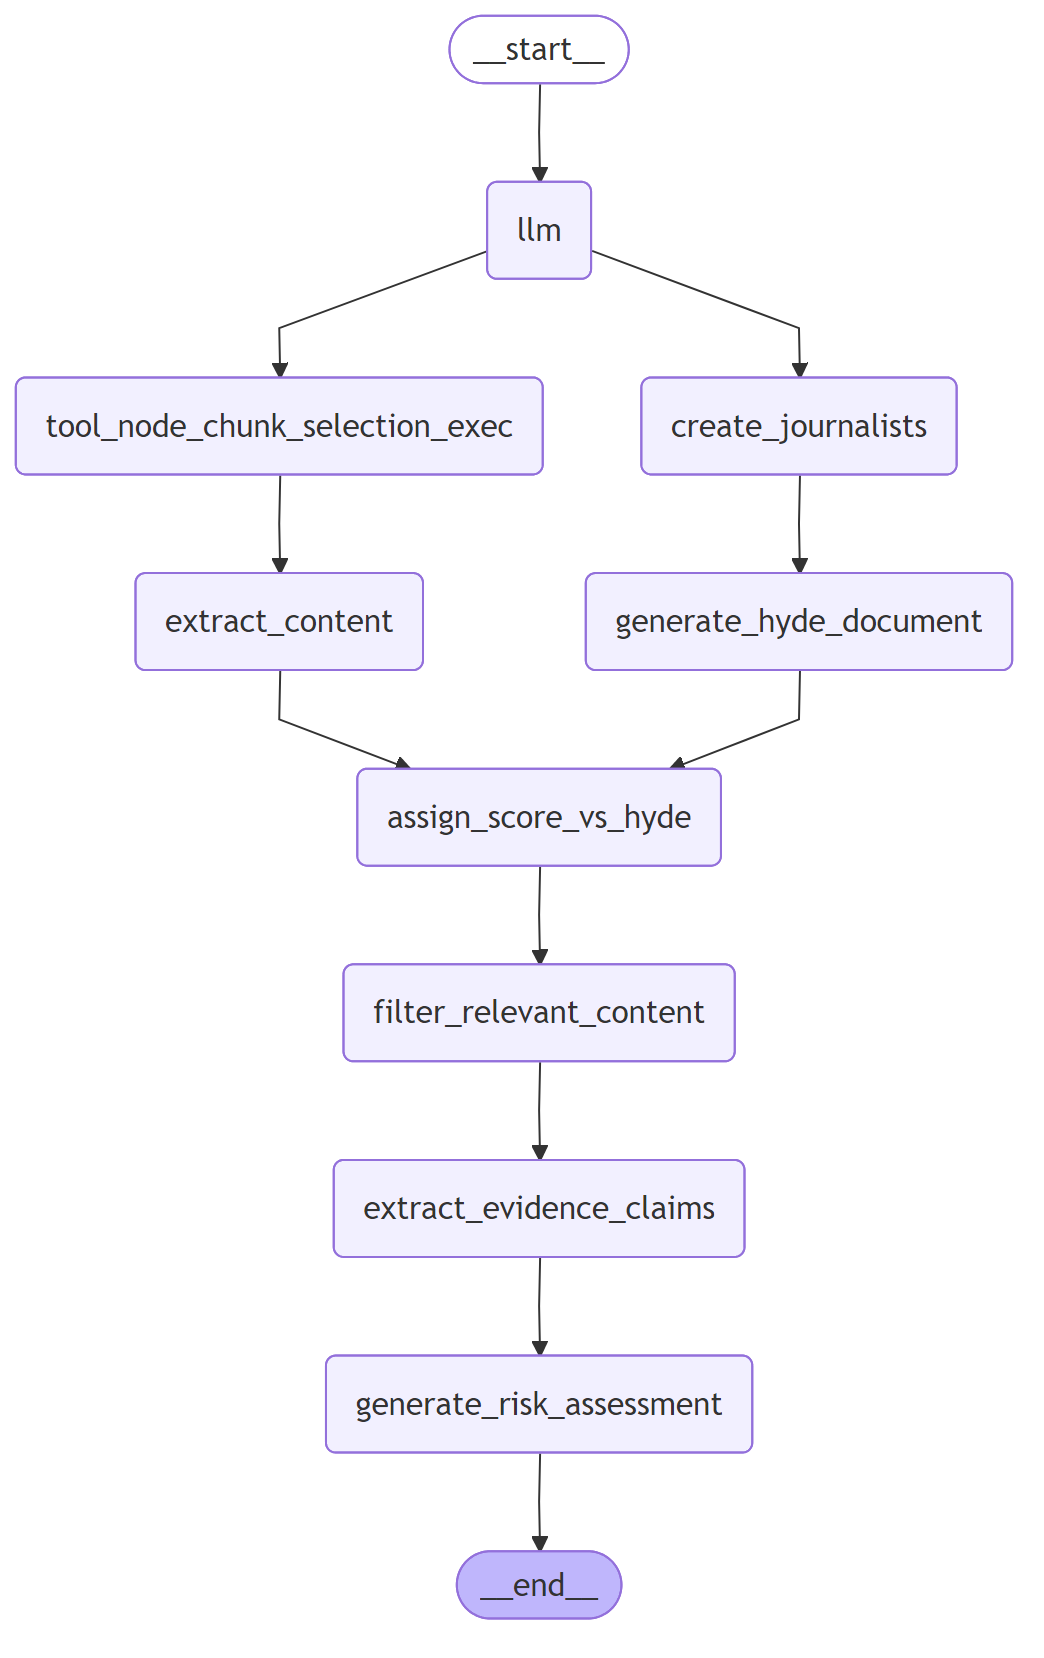

True

In [41]:
## add node to the workflow 


# assemble agent
builder = StateGraph(UnifiedResearchState)

# content extraction
builder.add_node( "llm", llm_node)
builder.add_node( "tool_node_chunk_selection_exec", tool_node_chunk_selection_exec)
builder.add_node( "extract_content", extract_content)
builder.add_node( "generate_risk_assessment", generate_risk_assessment)
builder.add_node( "filter_relevant_content",filter_relevant_content)
  # the node DOES wait for all incoming edges to complete before

# hyde generation
builder.add_node( "create_journalists", create_journalists )
builder.add_node( "generate_hyde_document", generate_hyde_document )

# estimate score 
builder.add_node( "assign_score_vs_hyde" ,  assign_score_vs_hyde )

# evidence assessment 
builder.add_node( "extract_evidence_claims", extract_evidence_claims)

# logic 

# content extraction
builder.add_edge(START, "llm")
builder.add_edge( "llm", "tool_node_chunk_selection_exec")
builder.add_edge( "tool_node_chunk_selection_exec", "extract_content")
builder.add_edge( "extract_content", "assign_score_vs_hyde")  # Then end

# article writer
builder.add_edge( "llm" , "create_journalists")
builder.add_edge( "create_journalists" , "generate_hyde_document")
builder.add_edge( "generate_hyde_document" , "assign_score_vs_hyde" )
builder.add_edge( "assign_score_vs_hyde" , "filter_relevant_content" )
builder.add_edge( "filter_relevant_content" , "extract_evidence_claims" )
builder.add_edge( "extract_evidence_claims" , "generate_risk_assessment" )
builder.add_edge("generate_risk_assessment", END)  # Then end

# assemble agent
graph = builder.compile( )

mermaid_code = graph.get_graph(xray=True).draw_mermaid()
render_mermaid_graph(mermaid_code)



In [42]:
# test 
# Moldretail
# Lukoil  Wachovia Bank     HSBC    Dankse Bank Moldindconbank
# Finpar Invest
# trans oil
# danube logistics

# try different search algoriths
# LLM as local 
# juridical cases in pdf , justice md

initial_message = [ HumanMessage(content = "Lukoil" )  ]
results = graph.invoke(   
               {
                    "messages" : initial_message,
                    "max_journalists": 3,
                    "journalists": [],  # Will be populated by create_journalists node
                    "hyde_list": [],     # Will be populated by generate_hyde_document node
                    "num_reques_per_lang":3
                    
                } )
# "max_journalists": 6, 10 links per language 

Executing llm_node...
Updated human message:  Lukoil money laundering criminal activity
Executing create_journalists ... 
System Instructions:  

You are creating exactly 3 AI journalist personas to analyze 
the SAME financial-crime topic from 
Executing tool_node_chunk_selection_exec...
Executing google_search_payload ...
Executing create_journalists Done 
Translated 'Lukoil money laundering criminal activity' -> 'Lukoil spălare de bani activitate infracțională' (Romanian)
Additional search terms:  Lukoil Lukoil România Lukoil SA Lukoil SRL spălare bani spălare-de-bani spălare-fonduri infracțiuni financiare infracțiune financiară activitate infracțională criminalitate financiară fraudă financiară corupție evaziune delicte financiare conformitate financiară finanțare ilicită încălcări AML încălcări reglementări sancțiuni ocolite
Executing google_search_payload DONE 
Executing google_search_payload ...
Translated 'Lukoil money laundering criminal activity' -> 'Lukoil money laundering cr

In [43]:
results

{'messages': [HumanMessage(content='Lukoil money laundering criminal activity', additional_kwargs={}, response_metadata={}, id='b1ef3333-adb1-4329-aec2-1f068585f134'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 1072, 'total_tokens': 1229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CamxYQcToY1sLAbq6mkKjfaiQ95yI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--4fcfecea-b5b0-470e-abb4-a6592d26d901-0', tool_calls=[{'name': 'google_search', 'args': {'query': 'Lukoil money laundering criminal activity', 'num_results': 3, 'hl': 'ro', 'lr': 'lang_ro', 'dateRestrict': 'y3', 'wi

In [44]:
summary_res = results.get("messages", None)
print( summary_res[-1].content )

**EXECUTIVE SUMMARY**

Lukoil is currently subject to U.S. sanctions, with a notable enforcement action involving the seizure of a $45 million aircraft by U.S. authorities in 2022. There is no evidence of fines paid to date, but the scale of the asset seizure and ongoing sanction status indicate unresolved and significant compliance risk. The most serious issue is the violation of U.S. sanctions and export controls, directly tied to Russia, with potential regional impacts extending to Romania and Moldova. The risk is ongoing, as evidenced by recent references to sanctions as of 2025.

**VIOLATION ANALYSIS**

- **What They Did Wrong:**  
  Lukoil violated U.S. sanctions and export controls related to Russia, resulting in a federal warrant for the seizure of a $45 million aircraft (Boeing 737-7EM) on August 31, 2022.  
- **When:**  
  The aircraft seizure occurred in September 2022.  
  Lukoil remains subject to U.S. sanctions as of November 2025, with regional implications for fuel supp

#### Select components to export

In [45]:
## data used for the conclusion
evidence_collection = [] 
for elem in results.get("search_results_raw"):
    if elem.summary:
        out = elem.model_dump( exclude={"raw_content", "hyde_score"} )
        evidence_collection.append(out)
        
evidence_collection    

[]

In [46]:
## data used for the conclusion
evidence_collection = [] 
for elem in results.get("search_results"):
    if elem.summary:
        out = elem.model_dump( exclude={"raw_content", "hyde_score"} )
        evidence_collection.append(out)
        
evidence_collection    

[{'displayLink': 'moldova.europalibera.org',
  'link': 'https://moldova.europalibera.org/a/politia-organizatia-criminala-sor-pregatea-coruperea-alegatorilor-la-parlamentarele-din-toamna/33497745.html',
  'summary': "The content mentions that the Republic of Moldova is aligning with sanctions and is targeting the takeover of Lukoil-Moldova's assets. It also references American sanctions against Lukoil and discusses recommendations from the National Bank of Moldova to local banks in the context of these sanctions. However, no specific details about the sanctions, such as dates, amounts, or legal proceedings, are provided in the content.",
  'claim_type': 'sanction_listing',
  'date_published': 'Unknown'},
 {'displayLink': 'home.treasury.gov',
  'link': 'https://home.treasury.gov/news/press-releases/jy2623',
  'summary': 'No financial crime or compliance information is present in the content regarding Lukoil. The content mentions that a private security firm associated with Eduard Benders

In [47]:
links_collection = []
for elem in results.get("evidence_claims"):
        out = elem.model_dump()
        links_collection.append(out)
        
links_collection        

[{'claim_text': 'On August 31, 2022, the U.S. District Court for the Southern District of Texas issued a warrant to seize a $45 million Boeing 737-7EM aircraft owned by PJSC LUKOIL, following an investigation into violations of U.S. sanctions and export controls related to Russia.',
  'claim_type': 'sanction_listing',
  'supporting_urls': ['https://www.ice.gov/news/releases/us-obtains-warrant-seize-45m-aircraft-owned-russian-energy-company-following'],
  'date_publish': '2022-09-01'},
 {'claim_text': 'Lukoil is subject to US sanctions, which could impact fuel supply in the region, as mentioned in the context of Romania requesting a delay in the implementation of these sanctions and potential effects on Moldova.',
  'claim_type': 'sanction_listing',
  'supporting_urls': ['https://www.ziarulnational.md/video-regele-contrabandei-cu-tigari-spre-romania-retinut-la-chisinau-dosar-de-75-de-milioane-de-lei-case-si-masini-de-lux-dar-si-50-de-arme/'],
  'date_publish': '2025-11-08'}]

In [48]:
summary_res = results.get("messages", None)
print( summary_res[-1].content )

**EXECUTIVE SUMMARY**

Lukoil is currently subject to U.S. sanctions, with a notable enforcement action involving the seizure of a $45 million aircraft by U.S. authorities in 2022. There is no evidence of fines paid to date, but the scale of the asset seizure and ongoing sanction status indicate unresolved and significant compliance risk. The most serious issue is the violation of U.S. sanctions and export controls, directly tied to Russia, with potential regional impacts extending to Romania and Moldova. The risk is ongoing, as evidenced by recent references to sanctions as of 2025.

**VIOLATION ANALYSIS**

- **What They Did Wrong:**  
  Lukoil violated U.S. sanctions and export controls related to Russia, resulting in a federal warrant for the seizure of a $45 million aircraft (Boeing 737-7EM) on August 31, 2022.  
- **When:**  
  The aircraft seizure occurred in September 2022.  
  Lukoil remains subject to U.S. sanctions as of November 2025, with regional implications for fuel supp